<a href="https://colab.research.google.com/github/lorenzrossi/InfoRet_SemanticSimilarity/blob/main/InfoRet_Semantic_Similarity_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, classification_report, hamming_loss
import shutil 
import sys
import time, datetime, json

!pip install opendatasets
import opendatasets as op

import os

from keras_preprocessing.sequence import pad_sequences

# NLTK
import nltk as nlp
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
nlp.download('stopwords')
nlp.download('popular')
stop_words = stopwords.words('english')

# PYTORCH
!pip install transformers~=2.11.0
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, AdamWeightDecay, get_linear_schedule_with_warmup
import random
import gc

import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--data_dir', default='data',
                    help="Directory to download dataset")
parser.add_argument('--preprocessed_dir', default='preprocessed_data',
                    help="Directory to save preprocessed datasets")
parser.add_argument('--model_dir', default="saved-model",
                    help="Directory to save model after training")

parser.add_argument('--config', default="config.ini",
                    help="INI file for model configuration")

parser.add_argument('--epochs', help="Number of epochs to train for")
parser.add_argument('--batch_size',
                    help="Batch Size for Training/Validation/Testing on dataset")

parser.add_argument('--download_dataset', action='store_true',
                    help="If set, download the dataset to a specified location")
parser.add_argument('--bert_size', default="base", choices=["base", "large"],
                    help="Size of pretrained BERT to use (base or large)")
parser.add_argument('--cased', default=False,
                    help="Use argument when you think casing is important")
parser.add_argument('--num_labels',
                    help="Number of labels to classify for given dataset")

parser.add_argument('--output_attentions', action='store_true',
                    help="Output attention values from BERT Model")
parser.add_argument('--output_hidden_states', action='store_true',
                    help="Output embeddings generated from BERT layers")
parser.add_argument('--gpu', action='store_true',
                    help="Use GPU for training if available")
parser.add_argument('--predict_on_test', action='store_true',
                    help="Load model from file and run on test set")
parser.add_argument('--no_train', action='store_true',
                    help="Don't train model, load model and quit")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data] 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 674.8/674.8 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.4 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=53c35ef2587405b9b20dc5756fd74d9a0955a47e7bf27efbe30f28780f9d5fd2
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


_StoreTrueAction(option_strings=['--no_train'], dest='no_train', nargs=0, const=True, default=False, type=None, choices=None, help="Don't train model, load model and quit", metavar=None)

In [2]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
# bcc30972b8b9f25c2bc6c0a46d8f4d62

--2023-01-24 07:49:26--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-24 07:49:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-01-24 07:52:06 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [3]:
op.download("https://www.kaggle.com/datasets/stanfordu/stanford-natural-language-inference-corpus")
url = "https://www.kaggle.com/datasets/stanfordu/stanford-natural-language-inference-corpus"
dataset_folder ='stanford-natural-language-inference-corpus'
preprocessed_folder = 'snli-preprocessed'
saved_model_location = 'saved_models'

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lorenzrossi
Your Kaggle Key: ··········


100%|██████████| 44.4M/44.4M [00:00<00:00, 164MB/s]


In [4]:
SPECIAL_TOKENS = {
    'CLS': ['[CLS]'],
    'SEP': ['[SEP]']
}

SNLI_DATASET_URL = {
    "train_folder": "stanford-natural-language-inference-corpus/snli_1.0_train.csv",
    "validation_folder": "stanford-natural-language-inference-corpus/snli_1.0_dev.csv",
    "test_folder": "stanford-natural-language-inference-corpus/snli_1.0_test.csv"
}

SNLI_FILE_NAMES = {
    "train": "snli_1.0_train.csv",
    "validation": "snli_1.0_dev.csv",
    "test": "snli_1.0_test.csv"
}

# PREPROCESSING

In [5]:
# Hyperparameters for preprocessing, tokenization and word embedding

max_len_tokens = 256

dataset_labels = {"contradiction": 0,
"entailment": 1,
"neutral": 2}

DATASET_LABELS = {}
for k, v in dataset_labels.items():
    DATASET_LABELS[k] = int(v)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [32]:
DATASET_LABELS

{'contradiction': 0, 'entailment': 1, 'neutral': 2}

In [85]:
class SNLIDataset(object):
    """
    Class to handle datasets and
    preprocess them in order to pass them on
    to the model for training/testing
    """

    def __init__(
        self, tokenizer, dataset_folder, preprocessed_folder, batch_size,
        max_len_tokens, dataset_labels, download_dataset=False, use_padding=True
    ):

        self.dataset_folder = dataset_folder
        self.preprocessed_folder = preprocessed_folder
        self.batch_size = batch_size
        self.use_padding = use_padding
        self.tokenizer = tokenizer
        self.max_len_tokens = max_len_tokens

        self.dataset_labels = dataset_labels

        if download_dataset:
            self.download_dataset()

        train_data = os.path.join(self.dataset_folder, SNLI_FILE_NAMES["train"])
        validation_data = os.path.join(self.dataset_folder, SNLI_FILE_NAMES["validation"])
        test_data = os.path.join(self.dataset_folder, SNLI_FILE_NAMES["test"])

        self.train_raw = pd.read_csv(train_data, index_col=1)
        self.train_raw = self.train_raw.sample(frac=0.2)
        
        self.eval_raw = pd.read_csv(validation_data, index_col=1)
        #self.eval_raw = self.eval_raw.sample(frac=0.5)

        self.test_raw = pd.read_csv(test_data, index_col=1)
        #self.test_raw = self.test_raw.sample(frac=0.5)

    def download_dataset(self):

       print("Downloading SNLI Dataset in CSV format")
       
       if not os.path.exists(self.dataset_folder):
           os.mkdir(self.dataset_folder)
       
       download_location = self.dataset_folder
       
       train_data_url = SNLI_DATASET_URL["train"]
       validation_data_url = SNLI_DATASET_URL["validation"]
       test_data_url = SNLI_DATASET_URL["test"]
       
       if os.path.exists(os.path.join(download_location)):
           print("Test Data already present")
       
       else:
           dataset = op.download(url, out=download_location)
       
       print(f"Dataset downloaded successfully in {download_location}")
       
       return

    def preprocess_dataset_util(self, dataset_df):
    
        tokenizer = self.tokenizer
        labels_dict = self.dataset_labels
        
        def tokenize_sentence(tokenizer, input_sentence):
        
            return tokenizer.tokenize(input_sentence)
            
        sentence_A = dataset_df.sentence1.to_numpy()
        sentence_B = dataset_df.sentence2.to_numpy()
        labels = dataset_df.gold_label.to_numpy()            
                 
        sentence_A_tokens = []
        sentence_B_tokens = []
        processed_labels = []

        for i, j, k in zip(sentence_A, sentence_B, labels):
            try:
                if k == '-':
                    continue
                
                t1 = tokenize_sentence(tokenizer, i)
                t2 = tokenize_sentence(tokenizer, j)
                
                sentence_A_tokens.append(t1)
                sentence_B_tokens.append(t2)
                
                label = labels_dict[k]
                processed_labels.append(label)
            
            except Exception as e:
                
                print(e)
                print("Skipping over sentence pair!")
                
                continue
        
        sentence_tokens = []
        input_ids = []
        token_lengths = []
        
        CLS_TOKEN = SPECIAL_TOKENS['CLS']
        SEP_TOKEN = SPECIAL_TOKENS['SEP']
        
        for i, j in zip(sentence_A_tokens, sentence_B_tokens):
        
            sentence = CLS_TOKEN + i + SEP_TOKEN + j + SEP_TOKEN
            
            token_ids = tokenizer.convert_tokens_to_ids(sentence)     
            sentence_tokens.append(sentence)
            
            token_lengths.append(len(token_ids))      
            input_ids.append(token_ids)
        
        return np.array(sentence_tokens), np.array(input_ids), np.array(token_lengths), np.array(processed_labels)
    
    def preprocess_dataset(self, d_partition="train_raw"):
    
        print(f"Preprocessing {d_partition} data")
        
        if d_partition.lower() not in ["train", "validation", "test"]:
            
            raise BaseException(
                "d_partition must be train, validation or test")
        
        if not os.path.exists(self.preprocessed_folder):
            os.mkdir(self.preprocessed_folder)
        
        preprocessed_location = self.preprocessed_folder
        file_name_base = os.path.join(preprocessed_folder, d_partition + "_")

        
        if os.path.exists(file_name_base + "tokens.npy"):           
            print("Retrieving tokens from .npy files")
            
            tokens = np.load(file_name_base + "tokens.npy", allow_pickle=True)
            ids = np.load(file_name_base + "token-ids.npy", allow_pickle=True)
            
            lengths = np.load(file_name_base + "token-lengths.npy", allow_pickle=True)
            labels = np.load(file_name_base + "labels.npy", allow_pickle=True)
        
        else:
            if d_partition.lower() == "train":
                dataset_df = self.train_raw
            
            elif d_partition.lower() == "validation":
                dataset_df = self.eval_raw
            
            else:
                dataset_df = self.test_raw
            
            tokens, ids, lengths, labels = self.preprocess_dataset_util(dataset_df)
            
            np.save(file_name_base + "tokens.npy", tokens)
            np.save(file_name_base + "token-ids.npy", ids)
            np.save(file_name_base + "token-lengths.npy", lengths)
            np.save(file_name_base + "labels.npy", labels)
        
        print(f"Saving preprocessed {d_partition} data")
        
        return (tokens, ids, lengths, labels)
    
    def pad_and_create_attention_masks(self, input_ids):      
        max_len_tokens = self.max_len_tokens       
        if self.use_padding:
            input_ids = pad_sequences(input_ids, maxlen=max_len_tokens, dtype="long", value=0, truncating="post", padding="post")
        
        attention_masks = []       
        for sentence in input_ids:
            attention_mask = [int(token_id > 0) for token_id in sentence]
            attention_masks.append(attention_mask)
        
        return input_ids, attention_masks
    
    def convert_data_to_tensor_dataset(self, tokens, attention_masks, labels):
        
        batch_size = self.batch_size 

        tokens = torch.tensor(tokens)       
        attention_masks = torch.tensor(attention_masks)       
        labels = torch.tensor(labels)   

        data = TensorDataset(tokens, attention_masks, labels)
        sampler = RandomSampler(data)        
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        
        return (data, sampler, dataloader)
    
    def labels(self):
        return self.dataset_labels

In [86]:
dataset = SNLIDataset(tokenizer = tokenizer, 
                      dataset_folder = dataset_folder, 
                      preprocessed_folder = preprocessed_folder, 
                      batch_size = 32, 
                      max_len_tokens = 256, 
                      dataset_labels = DATASET_LABELS, 
                      download_dataset=False, 
                      use_padding=True)

# Tokenization

In [87]:
train_tokens, train_input_ids, train_token_lenghts, train_labels = dataset.preprocess_dataset(d_partition="train")
validation_tokens, validation_input_ids, validation_token_lenghts, validation_labels = dataset.preprocess_dataset(d_partition="validation")
test_tokens, test_input_ids, test_token_lenghts, test_labels = dataset.preprocess_dataset(d_partition="test")
print("Padding inputs and creating attention masks")

Preprocessing train data
Retrieving tokens from .npy files
Saving preprocessed train data
Preprocessing validation data
Retrieving tokens from .npy files
Saving preprocessed validation data
Preprocessing test data
Retrieving tokens from .npy files
Saving preprocessed test data
Padding inputs and creating attention masks


# Word embedding

In [88]:
train_input_ids, train_attention_masks = dataset.pad_and_create_attention_masks(train_input_ids)

validation_input_ids, validation_attention_masks = dataset.pad_and_create_attention_masks(validation_input_ids)

test_input_ids, test_attention_masks = dataset.pad_and_create_attention_masks(test_input_ids)

print("Converting dataset to PyTorch TensorDataset")

Converting dataset to PyTorch TensorDataset


In [89]:
train_data, train_sampler, train_dataloader = dataset.convert_data_to_tensor_dataset(train_input_ids, train_attention_masks, train_labels)

validation_data, validation_sampler, validation_dataloader = dataset.convert_data_to_tensor_dataset(validation_input_ids, validation_attention_masks, validation_labels)

test_data, test_sampler, test_dataloader = dataset.convert_data_to_tensor_dataset(test_input_ids, test_attention_masks, test_labels)

# BERT

In [11]:
class BERTModel:

    def __init__(self, train_dataloader, num_labels, model_size, cased,
                 output_attentions, output_hidden_states,
                 optimizer, lr, eps, beta1, beta2,
                 weight_decay, correct_bias, epochs):
        """
            Args:
            train_dataloder: (torch.utils.data.TensorDataset) Dataloder for the Training Set
            num_labels: (int) Number of output labels
            model_size: (str) Size of BERT Model ["base", "large"]
            cased: (bool) Use cased or uncased BERT model
            output_attentions: (bool) Output attention values from BERT Model
            output_hidden_states: (bool) Output embeddings generated from BERT layers
            optimizer: (str) Name of the Optimizer ["AdamW", "AdamWeightDecay"]
            lr: (float) Learning Rate for the optimizer
            eps: (float) Epsilon value for optimizer
            beta1: (float) Beta1 value for Adam optimizer
            beta2: (float) Beta2 value for Adam optimizer
            weight_decay: (float) Weight Decay value for Adam optimizer
            correct_bias: (float) Correct for bias terms in Adam Optimizer, default = True
            epochs: (int) Number of epochs to run the model.
        """

        self.num_labels = num_labels
        self.model_size = model_size
        self.cased = cased
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states

        self.lr = lr
        self.eps = eps
        self.beta1 = beta1
        self.beta2 = beta2
        self.weight_decay = weight_decay
        self.correct_bias = correct_bias

        self._train_dataloader = train_dataloader
        self._epochs = epochs

        cased_ = "uncased" if not cased else "cased"
        model_name = f"bert-{model_size}-{cased_}"

        model = BertForSequenceClassification.from_pretrained(
                    model_name,
                    num_labels=num_labels,
                    output_attentions=output_attentions,
                    output_hidden_states=output_hidden_states
        )

        if optimizer == "AdamWeightDecay":
            optimizer = AdamWeightDecay(model.parameters(), learning_rate=lr, 
                                        beta_1=beta1, beta_2=beta2, epsilon=eps, weight_decay_rate=weight_decay)
        else:
            optimizer = AdamW(model.parameters(), lr=lr, eps=eps, 
                              betas=(beta1, beta2), weight_decay=weight_decay, correct_bias=correct_bias)

        total_steps = len(train_dataloader) * epochs

        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=0,
                                                    num_training_steps=total_steps)

        self._optimizer = optimizer
        self._model = model
        self._scheduler = scheduler

    def model(self):
        return self._model

    def optimizer(self):
        return self._optimizer

    def scheduler(self):
        return self._scheduler

    def epochs(self):
        return self._epochs

    def train_dataloader(self):
        return self._train_dataloader

In [12]:
EPOCHS = 4
BATCH_SIZE = 32
MODEL_PARAMS = {
    'learning_rate': 2e-05,
    'epsilon': 1e-08,
    'beta1': 0.9,
    'beta2': 0.999,
    'weight_decay': 0.0,
    'correct_bias': True
}

grad_clip_value = 1.0
batch_print_freq = 200
seed_value = 42

DOWNLOAD_DATASET = False
if SNLIDataset.download_dataset:
    DOWNLOAD_DATASET = True

MODEL_SIZE = "base"
CASED = "uncased"

num_labels = len(DATASET_LABELS)

#USE_GPU = True
#
#RUN_PREDICTIONS = True
#NO_TRAIN = True

model_name = f"bert-{MODEL_SIZE}-{CASED}"

BERTModel = BERTModel(
      train_dataloader=train_dataloader,
      num_labels = num_labels,
      model_size = MODEL_SIZE,
      cased = CASED,
      output_attentions = True,
      output_hidden_states = True,
      optimizer = "AdamW",
      lr = MODEL_PARAMS["learning_rate"],
      eps = MODEL_PARAMS["epsilon"],
      beta1 = MODEL_PARAMS["beta1"],
      beta2 = MODEL_PARAMS["beta2"],
      weight_decay = MODEL_PARAMS["weight_decay"],
      correct_bias = MODEL_PARAMS["correct_bias"],
      epochs=EPOCHS
    )

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

# Training and evaluation

In [94]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [95]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [96]:
# Train and evaluation
def train_and_evaluate_bert(BERTModel, validation_dataloader, use_gpu, seed_value, batch_print_freq, grad_clip_value):
    """
    Train the BERT Model
    Args:
        BERTModel: (models.bert) Object of BERTModel class, containing model, optimizer and scheduler
        validation_dataloder: (torch.utils.data.TensorDataset) Dataloder for the Validation Set
        use_gpu: (bool) Use GPU if available for training
        seed_value: (int) Seed Value for random number generation
        batch_print_freq: (int) Number of batches after which info is logged
        grad_clip_value: (float) Max value of gradient, higher gradients are clipped to this value
    """

    if use_gpu and torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"There are {torch.cuda.device_count()} GPU(s) available")
        print(f"Using {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

    model = BERTModel.model()
    optimizer = BERTModel.optimizer()
    scheduler = BERTModel.scheduler()
    epochs = BERTModel.epochs()
    train_dataloader = BERTModel.train_dataloader()

    print("Model, Optimizer and Scheduler setup successfully!")

    if use_gpu:
        model.cuda()

    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if use_gpu:
        torch.cuda.manual_seed_all(seed_value)

    loss_values = []
    metrics = []

    print("Training started")

    t = range(epochs)
    for epoch in t:
        epMetric = {}
        print(f"Epoch {epoch + 1} / {epochs}")
        epMetric["epoch"] = epoch + 1
        start_time = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            if step % batch_print_freq == 0 and not step == 0:
                elapsed = time.time() - start_time
                time_per_batch = elapsed / step
                time_remaining = (len(train_dataloader) -
                                  step) * time_per_batch
                print(f"\nBatch {step} of {len(train_dataloader)}. Elapsed: {format_time(elapsed)}")
                print(f"Time left in this epoch: {format_time(time_remaining)}")

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()

            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels)

            loss = output[0]
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)

        p_time = time.time()
        time_taken_train = format_time(p_time - start_time)

        epMetric["time_taken_train"] = time_taken_train
        epMetric["epoch_avg_loss"] = avg_train_loss

        print(f"\n Average Training Loss: {avg_train_loss} ")
        print(f"Training Epoch Time: {time_taken_train} \n")

        print("Validation")

        start_time = time.time()
        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps = 0

        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)

            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1

        p_time = time.time()
        time_taken_validation = format_time(p_time - start_time)
        validation_accuracy = eval_accuracy / nb_eval_steps

        epMetric["time_taken_validation"] = time_taken_validation
        epMetric["validation_accuracy"] = validation_accuracy

        print(f"Accuracy: {validation_accuracy}")
        print(f"Validation Took: {time_taken_validation}")

        metrics.append(epMetric)

    print("Training Complete")

    return (model, metrics)

In [97]:
def load_model_from_file(saved_model_location):

    model_weight_dir = saved_model_location

    if not os.path.exists(model_weight_dir):
        raise Exception(f"Directory {saved_model_location} doesn't exist")

    model = BertForSequenceClassification.from_pretrained(
        model_weight_dir,
        output_hidden_states=True
    )

    tokenizer = BertTokenizer.from_pretrained(model_weight_dir)

    print(f"Loaded pretrained model and tokenizer from {model_weight_dir}")

    return (model, tokenizer)


def run_model_on_test_set(test_dataloader, saved_model_location, use_gpu, batch_print_freq):

    if use_gpu and torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"There are {torch.cuda.device_count()} GPU(s) available")
        print(f"Using {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

    model, _ = load_model_from_file(saved_model_location)
    model.cuda()

    predictions, true_labels = [], []
    start_time = time.time()

    for batch in test_dataloader:

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      #batch = tuple(t.to(device) for t in batch)
      #b_input_ids, b_input_mask, b_labels = batch

      with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)

            logits = outputs[0]

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.detach().cpu().numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

            predictions = np.concatenate(predictions, axis=0)
            true_labels = np.concatenate(true_labels, axis=0)

      print('Done with Predictions!')

      return (predictions, true_labels)

In [116]:
def evaluate_model_on_test_set(test_dataloader, dataset_labels,
                               saved_model_location, use_gpu, batch_print_freq
                               ):

    predictions, true_labels = run_model_on_test_set(
        test_dataloader=test_dataloader,
        saved_model_location=saved_model_location,
        use_gpu=use_gpu,
        batch_print_freq=batch_print_freq
    )
    pred_labels = np.argmax(predictions, axis=1)

    exact_match_score = accuracy_score(true_labels, pred_labels)
    hamming_score = hamming_loss(true_labels, pred_labels)

    labels = list(dataset_labels.values())
    target_names = list(dataset_labels.keys())

    prec_recall_report = classification_report(true_labels, pred_labels, labels=labels, target_names=target_names, output_dict=True)

    evaluation = {}
    evaluation["exact_march_score"] = exact_match_score
    evaluation["hamming_score"] = hamming_score
    evaluation["prec_recall_report"] = prec_recall_report

    cf_matrix = confusion_matrix(true_labels, pred_labels)
    matrix = sns.heatmap(cf_matrix, annot=True)
    matrix.xaxis.set_ticks_position('top') 
    matrix.set(xlabel='prediction', ylabel='Gold label')
    plt.title('Confusion Matrix\n0=Neutral, 1=Entailment, 2=Contradiction')
    plt.show()

    print(cf_matrix)

    return evaluation

In [99]:
model, metrics = train_and_evaluate_bert(
    BERTModel=BERTModel,
    validation_dataloader=validation_dataloader,
    use_gpu = True,
    seed_value = seed_value,
    batch_print_freq=batch_print_freq,
    grad_clip_value=grad_clip_value
)

There are 1 GPU(s) available
Using A100-SXM4-40GB
Model, Optimizer and Scheduler setup successfully!
Training started
Epoch 1 / 4

Batch 200 of 3434. Elapsed: 0:01:07
Time left in this epoch: 0:18:03

Batch 400 of 3434. Elapsed: 0:02:14
Time left in this epoch: 0:16:54

Batch 600 of 3434. Elapsed: 0:03:21
Time left in this epoch: 0:15:47

Batch 800 of 3434. Elapsed: 0:04:27
Time left in this epoch: 0:14:40

Batch 1000 of 3434. Elapsed: 0:05:34
Time left in this epoch: 0:13:33

Batch 1200 of 3434. Elapsed: 0:06:41
Time left in this epoch: 0:12:26

Batch 1400 of 3434. Elapsed: 0:07:48
Time left in this epoch: 0:11:19

Batch 1600 of 3434. Elapsed: 0:08:54
Time left in this epoch: 0:10:13

Batch 1800 of 3434. Elapsed: 0:10:01
Time left in this epoch: 0:09:06

Batch 2000 of 3434. Elapsed: 0:11:08
Time left in this epoch: 0:07:59

Batch 2200 of 3434. Elapsed: 0:12:15
Time left in this epoch: 0:06:52

Batch 2400 of 3434. Elapsed: 0:13:21
Time left in this epoch: 0:05:45

Batch 2600 of 3434. E

In [117]:
output_dir = saved_model_location

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

with open(os.path.join(output_dir, "model-metrics.json"), "w") as f:
    model_metrics = json.dumps(metrics)
    f.write(model_metrics)

Saving model to saved_models


# Prediction and model performance checking

There are 1 GPU(s) available
Using A100-SXM4-40GB
Loaded pretrained model and tokenizer from saved_models
Done with Predictions!


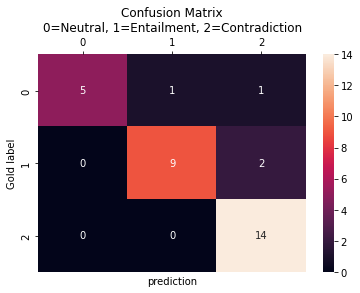

[[ 5  1  1]
 [ 0  9  2]
 [ 0  0 14]]


In [118]:
testing = evaluate_model_on_test_set(
    test_dataloader=test_dataloader,
    dataset_labels=dataset_labels,
    saved_model_location=saved_model_location,
    use_gpu = True,
    batch_print_freq=batch_print_freq
)

In [119]:
with open(saved_model_location + "model-evaluation.json", "w") as f:
        output = json.dumps(testing)
        f.write(output)

In [120]:
output

'{"exact_march_score": 0.875, "hamming_score": 0.125, "prec_recall_report": {"contradiction": {"precision": 1.0, "recall": 0.7142857142857143, "f1-score": 0.8333333333333333, "support": 7}, "entailment": {"precision": 0.9, "recall": 0.8181818181818182, "f1-score": 0.8571428571428572, "support": 11}, "neutral": {"precision": 0.8235294117647058, "recall": 1.0, "f1-score": 0.9032258064516129, "support": 14}, "accuracy": 0.875, "macro avg": {"precision": 0.907843137254902, "recall": 0.8441558441558442, "f1-score": 0.8645673323092677, "support": 32}, "weighted avg": {"precision": 0.8884191176470588, "recall": 0.875, "f1-score": 0.8720958141321045, "support": 32}}}'

In [ ]:
## Plot loss
#plt.plot(list(range(1, max_epoch+1)), train_loss_, color='red', marker='o')
#plt.plot(list(range(1, max_epoch+1)), eval_loss_, color='green', marker='^')
#plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
#plt.title('Model loss\nEpoch = ' + str(max_epoch))
#plt.legend(['Train loss', 'Evaluation loss'])
#plt.xlabel('Epoch')
#plt.ylabel('Average cross entropy loss')
#plt.show()